(c) 2025 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import base libraries
import os
import glob
import gc
import pickle

# Import JAX-related libraries
import jax
from jax import random
import jax.numpy as jnp
from numpyro.optim import Adam
import numpyro

# Import numpy for array manipulation
import numpy as np
# Import statsmodels for statistical modeling
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
# Import scipy for special functions
import scipy as sp
# Import library to load h5ad files
import scanpy as sc
# Import pandas for data manipulation
import pandas as pd
# Import scribe
import scribe
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
scribe.viz.matplotlib_style()

# Import colors
color_palette = scribe.viz.colors()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory data analysis of yest single-cell RNA-seq datastes

In this notebook, we will explore the single-cell RNA-seqs datasets provided by
Annisa Dea from the Pinker lab in U. Chicago.

## Raw counts exploratory data analysis

**2025/02/04**

The dataset provided consists of a single `h5ad` file with the following structure. The dataset contains 6 distinct samples:
- `Standard1`
- `Standard2`
- `Standard3`
- `Standard4`
- `Glucose`
- `EthGly` (Ethanol/Glycerol)

Let's load the dataset and explore the structure.

In [2]:
# Define data directory
DATA_DIR = f"{scribe.utils.git_root()}/data/yeast"

# List all files in the data directory
file = glob.glob(f"{DATA_DIR}/*h5ad", recursive=True)

# Load the dataset
data = sc.read_h5ad(file[0])

# Explore the structure of the dataset
data

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 4507743 × 7127
    obs: 'batch'

Let's extract the different datasets from the `obs` object.

In [3]:
# Group by `batch` and extract index for each batch
df_group = data.obs.groupby('batch')

# Extract index for each batch
idxs = df_group.indices

# Extract data for each batch
data_batch = {k: data[v] for k, v in idxs.items()}

# Explore the structure of the dataset
data_batch

/tmp/ipykernel_36603/1679430660.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group = data.obs.groupby('batch')


{'Standard1': View of AnnData object with n_obs × n_vars = 855334 × 7127
     obs: 'batch',
 'Standard2': View of AnnData object with n_obs × n_vars = 792648 × 7127
     obs: 'batch',
 'Standard3': View of AnnData object with n_obs × n_vars = 904552 × 7127
     obs: 'batch',
 'Standard4': View of AnnData object with n_obs × n_vars = 785966 × 7127
     obs: 'batch',
 'Glucose': View of AnnData object with n_obs × n_vars = 618211 × 7127
     obs: 'batch',
 'EthGly': View of AnnData object with n_obs × n_vars = 551032 × 7127
     obs: 'batch'}

First, let's compute the total UMI counts per cell for each batch.

In [4]:
# Initialize dictionary to store total UMI counts per cell
umi_counts = {}

# Loop through each batch
for batch in data_batch.keys():
    # Get total UMI counts per cell and flatten from 1 x n matrix to array
    umi_counts[batch] = jnp.ravel(data_batch[batch].X.sum(axis=1))

Let's look at the distribution of total UMI counts per cell on each of the datasets.

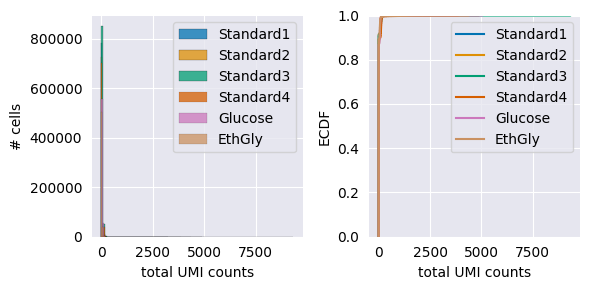

In [5]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch], bins=100, ax=ax[0], label=batch
    )
    sns.ecdfplot(umi_counts[batch], ax=ax[1], label=batch)

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend()
ax[1].legend()

plt.tight_layout()

There is massive variability between cells, but let's zoom in where most of the cells are.

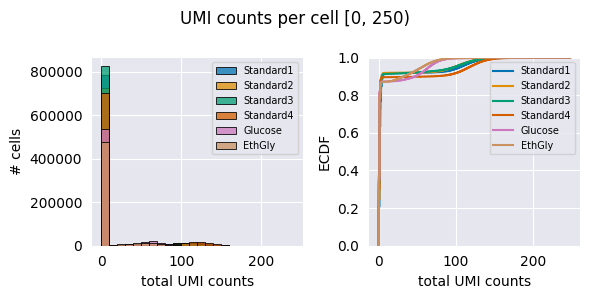

In [6]:
# Define upper limit
UMI_LIMIT = 250

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch][umi_counts[batch] < UMI_LIMIT], 
        bins=np.arange(0, UMI_LIMIT, 10), 
        ax=ax[0], 
        label=batch
    )
    sns.ecdfplot(
        umi_counts[batch][umi_counts[batch] < UMI_LIMIT], 
        ax=ax[1], 
        label=batch
    )

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)

# Add global title
fig.suptitle(f'UMI counts per cell [0, {UMI_LIMIT})')

plt.tight_layout()

When zooming in, we can see that there is a very large peak of cells with less than 10 UMI counts. Let's remove these cells and re-plot the distribution to focus on the main population that was measured.

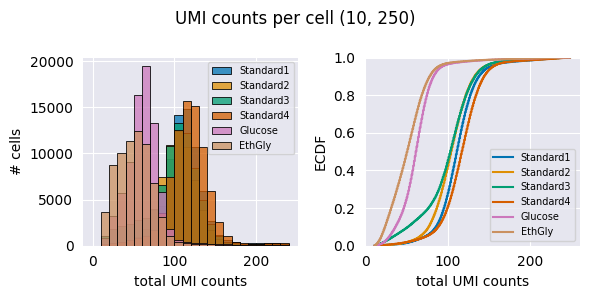

In [7]:
# Define upper limit
UMI_LIMITS = [10, 250]

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch][
            (umi_counts[batch] < UMI_LIMITS[1]) & 
            (umi_counts[batch] > UMI_LIMITS[0])
        ],
        bins=np.arange(0, UMI_LIMITS[1], 10), 
        ax=ax[0], 
        label=batch
    )
    sns.ecdfplot(
        umi_counts[batch][
            (umi_counts[batch] < UMI_LIMITS[1]) & 
            (umi_counts[batch] > UMI_LIMITS[0])
        ], 
        ax=ax[1], 
        label=batch
    )

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)

# Add global title
fig.suptitle(f'UMI counts per cell ({UMI_LIMITS[0]}, {UMI_LIMITS[1]})')

plt.tight_layout()

Let's now explore the second dataset. This dataset was generated with a novaseq
flowcell, so it has a deeper coverage.

In [8]:
# List all files in the data directory
file = glob.glob(f"{DATA_DIR}/*h5ad", recursive=True)

# Load the dataset
data = sc.read_h5ad(file[-1])

# Explore the structure of the dataset
data

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 9501827 × 7127
    obs: 'batch'

In [9]:
# Group by `batch` and extract index for each batch
df_group = data.obs.groupby('batch')

# Extract index for each batch
idxs = df_group.indices

# Extract data for each batch
data_batch = {k: data[v] for k, v in idxs.items()}

# Explore the structure of the dataset
data_batch

/tmp/ipykernel_36603/1679430660.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group = data.obs.groupby('batch')


{'Standard1_nova': View of AnnData object with n_obs × n_vars = 1653515 × 7127
     obs: 'batch',
 'Standard2_nova': View of AnnData object with n_obs × n_vars = 1741551 × 7127
     obs: 'batch',
 'Standard3_nova': View of AnnData object with n_obs × n_vars = 1697028 × 7127
     obs: 'batch',
 'Standard4_nova': View of AnnData object with n_obs × n_vars = 1926425 × 7127
     obs: 'batch',
 'Glucose_nova': View of AnnData object with n_obs × n_vars = 1271267 × 7127
     obs: 'batch',
 'EthGly_nova': View of AnnData object with n_obs × n_vars = 1212041 × 7127
     obs: 'batch'}

In [10]:
# Initialize dictionary to store total UMI counts per cell
umi_counts = {}

# Loop through each batch
for batch in data_batch.keys():
    # Get total UMI counts per cell and flatten from 1 x n matrix to array
    umi_counts[batch] = jnp.ravel(data_batch[batch].X.sum(axis=1))

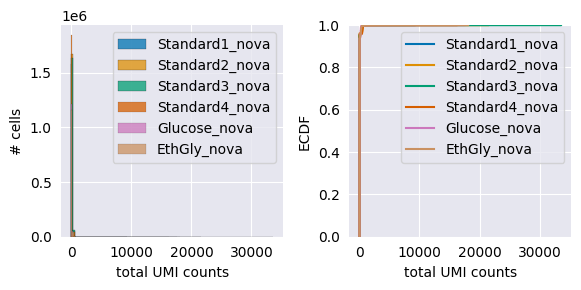

In [11]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch], bins=100, ax=ax[0], label=batch
    )
    sns.ecdfplot(umi_counts[batch], ax=ax[1], label=batch)

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend()
ax[1].legend()

plt.tight_layout()

/tmp/ipykernel_36603/4037924647.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


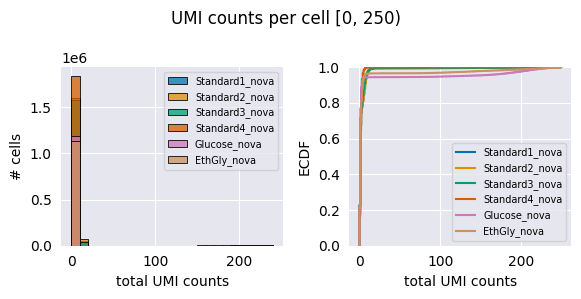

In [12]:
# Define upper limit
UMI_LIMIT = 250

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch][umi_counts[batch] < UMI_LIMIT], 
        bins=np.arange(0, UMI_LIMIT, 10), 
        ax=ax[0], 
        label=batch
    )
    sns.ecdfplot(
        umi_counts[batch][umi_counts[batch] < UMI_LIMIT], 
        ax=ax[1], 
        label=batch
    )

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)

# Add global title
fig.suptitle(f'UMI counts per cell [0, {UMI_LIMIT})')

plt.tight_layout()

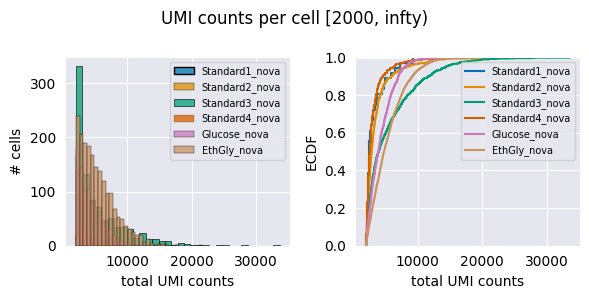

In [13]:
# Define upper limit
UMI_LIMIT = 2_000

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Loop through each batch
for i, batch in enumerate(umi_counts.keys()):
    # Plot distribution of total UMI counts per cell
    sns.histplot(
        umi_counts[batch][umi_counts[batch] > UMI_LIMIT], 
        # bins=np.arange(0, UMI_LIMIT, 10), 
        ax=ax[0], 
        label=batch
    )
    sns.ecdfplot(
        umi_counts[batch][umi_counts[batch] > UMI_LIMIT], 
        ax=ax[1], 
        label=batch
    )

# Set title and labels
ax[0].set_xlabel('total UMI counts')
ax[0].set_ylabel('# cells')
ax[1].set_xlabel('total UMI counts')
ax[1].set_ylabel('ECDF')

# Add legend
ax[0].legend(fontsize=7)
ax[1].legend(fontsize=7)

# Add global title
fig.suptitle(f'UMI counts per cell [{UMI_LIMIT}, infty)')

plt.tight_layout()

Let's now print the number of cells in each batch above the threshold.

In [15]:
# Define upper limit
UMI_LIMIT = 1_000

# Loop through each batch
for batch in umi_counts.keys():
    # Print number of cells above threshold
    print(f'{batch}: {np.sum(umi_counts[batch] > UMI_LIMIT)} cells')


Standard1_nova: 377 cells
Standard2_nova: 2142 cells
Standard3_nova: 1933 cells
Standard4_nova: 2515 cells
Glucose_nova: 1664 cells
EthGly_nova: 2798 cells
